In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

import src
from src.reload import deep_reload

In [122]:
def PrintLaTeXTabular(model,alpha=.05,label_substitutions={}):
	params=model._results.params
	tvalues=model._results.tvalues
	pvalues=model._results.pvalues
	names=np.array(list(dict(model.params).keys()))
	
	for idx in range(len(names)):

		name=names[idx]

		for key,val in label_substitutions.items():

			if key in name:

				names[idx]=name.replace(key,val)
				name=names[idx]

	params=params[pvalues<alpha]
	tvalues=tvalues[pvalues<alpha]
	names=names[pvalues<alpha]
	pvalues=pvalues[pvalues<alpha]

	name_lengths=[len(name) for name in names]

	name_length_order=np.append(0,np.argsort(name_lengths[1:])+1)


	params=params[name_length_order]
	tvalues=tvalues[name_length_order]
	names=names[name_length_order]
	pvalues=pvalues[name_length_order]

	out_string=""
	for i in range(len(names)):
		out_string+="\\hline {{\\small {} }} & {:.3f} & {:.3f} \\\\\n".format(
			names[i],params[i],pvalues[i])
	
	return out_string

In [5]:
results_directory = 'ExpResults/'

results_files = os.listdir(results_directory)

In [132]:
results = {}

for results_file in results_files:

    results[results_file.split('.')[0]] = pkl.load(
        open(results_directory + results_file, 'rb')
    )

In [133]:
deep_reload(src)

src.experiment.accessibility(results['Bolt_10'][2], 'time') / 3600

7.931522105084849

In [134]:
deep_reload(src)

outcomes = []

risk_attitude = {(0, .5): 'Aggressive', (0, 1): 'Neutral', (.5, 1): 'Cautious'}

for key, result in results.items():

    vehicle = key.split('_')[0]
    if vehicle == 'Model':
        vehicle = 'Model 3'

    result[0][2] = risk_attitude[result[0][2]]

    outcomes.append(
        [vehicle, *result[0], src.experiment.accessibility(result[2], 'time')]
    )

In [135]:
df_outcomes = pd.DataFrame(
    data = outcomes,
    columns = ['Vehicle', 'Multiplier', 'Reliability', 'Attitude', 'Expectation']
)

In [136]:
formula = (
    'Expectation~' +
    # 'Vehicle *' +
    'Multiplier *' +
    'Reliability *'
    'Attitude'
)

data = df_outcomes[df_outcomes['Vehicle'] == 'Bolt']

data['Reliability'] = (data['Reliability'] - .75) / (.95 - .75)
data['Multiplier'] = (data['Multiplier'] - 1) / (.5)
data['Expectation'] = data['Expectation'] / 3600

model = smf.ols(formula = formula, data = data).fit()

In [137]:
l = PrintLaTeXTabular(model)
print(l)

\hline {\small Intercept } & 8.557 & 0.000 \\
\hline {\small Multiplier } & -2.127 & 0.000 \\
\hline {\small Attitude[T.Neutral] } & 0.775 & 0.004 \\
\hline {\small Attitude[T.Cautious] } & 1.188 & 0.000 \\



In [138]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Expectation   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     68.64
Date:                Thu, 11 Apr 2024   Prob (F-statistic):           8.96e-11
Time:                        09:44:01   Log-Likelihood:                 14.357
No. Observations:                  27   AIC:                            -4.715
Df Residuals:                      15   BIC:                             10.84
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                       8.5567      0.159     53.830      0.000       8.218       8.896
Attitude[T.Cautious]                            1.1876      0.225      5.283      0.000       0.708       1.667
Attitude[T.Neutral]                             0.7750      0.225      3.447      0.004       0.296       1.254
Multiplier                                     -2.1268      0.246     -8.637      0.000      -2.652      -1.602
Multiplier:Attitude[T.Cautious]                 0.1738      0.348      0.499      0.625      -0.569       0.916
Multiplier:Attitude[T.Neutral]                 -0.2574      0.348     -0.739      0.471      -1.000       0.485
Reliability                                     0.0864      0.246      0.351      0.731      -0.439       0.611
Reliability:Attitude[T.Cautious]               -0.2096      0.348     -0.602      0.556      -0.952       0.533
Reliability:Attitude[T.Neutral]                -0.1953      0.348     -0.561      0.583      -0.938       0.547
Multiplier:Reliability                          0.1435      0.381      0.376      0.712      -0.670       0.957
Multiplier:Reliability:Attitude[T.Cautious]    -0.6802      0.540     -1.261      0.227      -1.830       0.470
Multiplier:Reliability:Attitude[T.Neutral]     -0.2341      0.540     -0.434      0.671      -1.384       0.916
==============================================================================
Omnibus:                        9.834   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                8.112
Skew:                          -1.223   Prob(JB):                       0.0173
Kurtosis:                       4.108   Cond. No.                         37.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [139]:
formula = (
    'Expectation~' +
    # 'Vehicle *' +
    'Multiplier *' +
    'Reliability *'
    'Attitude'
)

data = df_outcomes[df_outcomes['Vehicle'] == 'Model 3']

data['Reliability'] = (data['Reliability'] - .75) / (.95 - .75)
data['Multiplier'] = (data['Multiplier'] - 1) / (.5)
data['Expectation'] = data['Expectation'] / 3600

model = smf.ols(formula = formula, data = data).fit()

In [140]:
l = PrintLaTeXTabular(model)
print(l)

\hline {\small Intercept } & 5.840 & 0.000 \\
\hline {\small Multiplier } & -0.118 & 0.000 \\



In [143]:
7.684 - 6.486, 8.557 - 5.840

(1.1980000000000004, 2.7170000000000005)

In [148]:
50e3 * 8 * 60 / (550 * 1e3), 170e3 * 8 * 60 / (550 * 1e3)

(43.63636363636363, 148.36363636363637)

In [151]:
8 * 3.6e6 / (550e3) / 1.609

32.544211537375

In [142]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Expectation   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     23.39
Date:                Thu, 11 Apr 2024   Prob (F-statistic):           1.88e-07
Time:                        09:44:11   Log-Likelihood:                 82.220
No. Observations:                  27   AIC:                            -140.4
Df Residuals:                      15   BIC:                            -124.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                       5.8402      0.013    453.648      0.000       5.813       5.868
Attitude[T.Cautious]                           -0.0004      0.018     -0.024      0.981      -0.039       0.038
Attitude[T.Neutral]                            -0.0008      0.018     -0.044      0.966      -0.040       0.038
Multiplier                                     -0.1185      0.020     -5.940      0.000      -0.161      -0.076
Multiplier:Attitude[T.Cautious]                 0.0006      0.028      0.020      0.984      -0.060       0.061
Multiplier:Attitude[T.Neutral]                  0.0008      0.028      0.027      0.979      -0.059       0.061
Reliability                                    -0.0025      0.020     -0.125      0.902      -0.045       0.040
Reliability:Attitude[T.Cautious]                0.0002      0.028      0.008      0.994      -0.060       0.060
Reliability:Attitude[T.Neutral]                 0.0005      0.028      0.018      0.986      -0.060       0.061
Multiplier:Reliability                          0.0027      0.031      0.087      0.932      -0.063       0.069
Multiplier:Reliability:Attitude[T.Cautious]    -0.0004      0.044     -0.009      0.993      -0.094       0.093
Multiplier:Reliability:Attitude[T.Neutral]     -0.0004      0.044     -0.010      0.993      -0.094       0.093
==============================================================================
Omnibus:                       16.180   Durbin-Watson:                   2.182
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                4.770
Skew:                          -0.706   Prob(JB):                       0.0921
Kurtosis:                       1.501   Cond. No.                         37.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [94]:
expectations_m = df_outcomes[df_outcomes['Vehicle'] == 'Model 3']['Expectation'].mean()
expectations_b = df_outcomes[df_outcomes['Vehicle'] == 'Bolt']['Expectation'].mean()

(expectations_m - expectations_b) / 3600

-2.38828344806588

In [103]:
levels = {
    'rm': [1, 1.25, 1.5],
    'cr': [.75, .85, .95],
    'ra': ['Cautious', 'Neutral', 'Aggressive'],
}

connections = []

for rm in levels['rm']:
    for cr in levels['cr']:
        for ra in levels['ra']:
            connections.append([
                float(df_outcomes.loc[(
                    (df_outcomes['Vehicle'] == 'Bolt') &
                    (df_outcomes['Multiplier'] == rm) &
                    (df_outcomes['Reliability'] == cr) &
                    (df_outcomes['Attitude'] == ra) 
                )]['Expectation']) / 3600,
                float(df_outcomes.loc[(
                    (df_outcomes['Vehicle'] == 'Model 3') &
                    (df_outcomes['Multiplier'] == rm) &
                    (df_outcomes['Reliability'] == cr) &
                    (df_outcomes['Attitude'] == ra) 
                )]['Expectation']) / 3600,
           ])

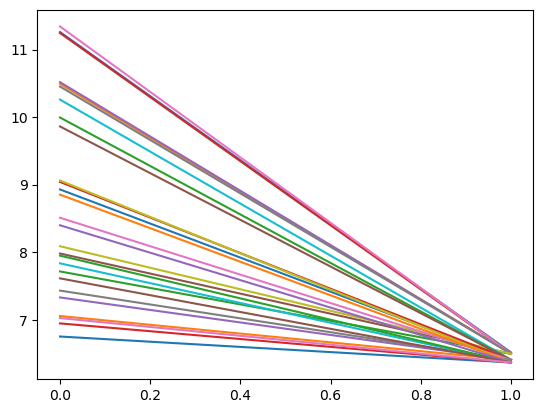

In [114]:
# plt.plot([[0, 1]] * len(connections), connections)

for c in connections:
    plt.plot([0, 1], c)

In [88]:
formula = (
    'Expectation~' +
    'Vehicle *' +
    'Multiplier *' +
    'Reliability *'
    'Attitude'
)

data = df_outcomes

data['Reliability'] = (data['Reliability'] - .75) / (.95 - .75)
data['Multiplier'] = (data['Multiplier'] - 1) / (.5)
data['Expectation'] = data['Expectation'] / 3600

model = smf.ols(formula = formula, data = data).fit()

In [89]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Expectation   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     419.4
Date:                Wed, 10 Apr 2024   Prob (F-statistic):           1.16e-31
Time:                        14:51:11   Log-Likelihood:                 55.100
No. Observations:                  54   AIC:                            -62.20
Df Residuals:                      30   BIC:                            -14.47
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                          7.6835      0.098     78.793      0.000       7.484       7.883
Vehicle[T.Model 3]                                                -1.1974      0.138     -8.683      0.000      -1.479      -0.916
Attitude[T.Cautious]                                               3.5792      0.138     25.954      0.000       3.298       3.861
Attitude[T.Neutral]                                                2.7662      0.138     20.058      0.000       2.485       3.048
Vehicle[T.Model 3]:Attitude[T.Cautious]                           -3.5623      0.195    -18.265      0.000      -3.961      -3.164
Vehicle[T.Model 3]:Attitude[T.Neutral]                            -2.7592      0.195    -14.147      0.000      -3.157      -2.361
Multiplier                                                        -0.9706      0.151     -6.425      0.000      -1.279      -0.662
Vehicle[T.Model 3]:Multiplier                                      0.8423      0.214      3.942      0.000       0.406       1.279
Multiplier:Attitude[T.Cautious]                                   -1.1687      0.214     -5.470      0.000      -1.605      -0.732
Multiplier:Attitude[T.Neutral]                                    -1.6270      0.214     -7.616      0.000      -2.063      -1.191
Vehicle[T.Model 3]:Multiplier:Attitude[T.Cautious]                 1.1501      0.302      3.806      0.001       0.533       1.767
Vehicle[T.Model 3]:Multiplier:Attitude[T.Neutral]                  1.6192      0.302      5.359      0.000       1.002       2.236
Reliability                                                        0.3910      0.151      2.588      0.015       0.083       0.700
Vehicle[T.Model 3]:Reliability                                    -0.3910      0.214     -1.830      0.077      -0.827       0.045
Reliability:Attitude[T.Cautious]                                  -0.3444      0.214     -1.612      0.117      -0.781       0.092
Reliability:Attitude[T.Neutral]                                   -0.5271      0.214     -2.467      0.020      -0.963      -0.091
Vehicle[T.Model 3]:Reliability:Attitude[T.Cautious]                0.3278      0.302      1.085      0.287      -0.289       0.945
Vehicle[T.Model 3]:Reliability:Attitude[T.Neutral]                 0.5207      0.302      1.723      0.095      -0.096       1.138
Multiplier:Reliability                                            -0.1001      0.234     -0.428      0.672      -0.578       0.378
Vehicle[T.Model 3]:Multiplier:Reliability                          0.1001      0.331      0.303      0.764      -0.576       0.776
Multiplier:Reliability:Attitude[T.Cautious]                       -0.6